In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir(os.path.join(os.getcwd(), '..', '..', 'src'))
print("Current working directory:", os.getcwd())

Current working directory: c:\archaeo-extraction-prompt-eval\prompt_enhancing\src


In [ ]:
from archaeo_super_prompt.dataset import MagohDataset, SamplingParams
import archaeo_super_prompt.modeling.train as training
import archaeo_super_prompt.modeling.predict as infering
import mlflow
import pandas as pd
from archaeo_super_prompt.visualization import mlflow_logging as mmlflow
from archaeo_super_prompt import visualization as visualizator
from archaeo_super_prompt.config.env import getenv_or_throw
from sklearn.pipeline import Pipeline
from sklearn import set_config

from pathlib import Path
from sklearn.base import BaseEstimator, TransformerMixin
from archaeo_super_prompt.utils.cache import get_cache_dir_for
import pandas as pd

class LoadScans(BaseEstimator, TransformerMixin):
    def __init__(self, cache_csv: Path):
        self.cache_csv = Path(cache_csv)
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        scans = pd.read_csv(self.cache_csv)
        scans = scans.drop_duplicates(subset=["id"])
        return X.merge(scans, on="id", how="inner")

CACHE_CSV = get_cache_dir_for("interim", "miscel") / "scans.csv"
SCANS_DF = pd.read_csv(CACHE_CSV)


In [ ]:
# mlflow server --host 127.0.0.1 --port 8887

#source ~/.venvs/vllm/bin/activate
#vllm serve ibm-granite/granite-vision-3.3-2b --host 0.0.0.0 --port 8005

In [5]:
EXP_NAME = "Complete training"
mlflow.set_tracking_uri(f"http://{getenv_or_throw("MLFLOW_HOST")}:{getenv_or_throw("MLFLOW_PORT")}")
mlflow.set_experiment(EXP_NAME)
mlflow.dspy.autolog(log_compiles=True, log_evals=True, log_traces_from_compile=True)
pd.set_option('display.max_columns', None)
set_config(display="diagram")

2025/08/25 12:09:11 INFO mlflow.tracking.fluent: Experiment with name 'Complete training' does not exist. Creating a new experiment.


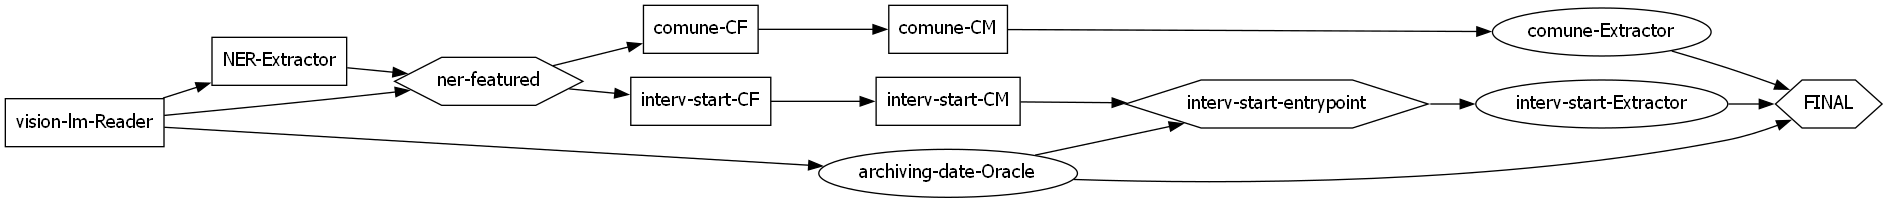

In [14]:
expected_final_pipeline = infering.build_complete_inference_dag(training.get_training_dag())
expected_final_pipeline

In [ ]:
from archaeo_super_prompt.dataset import MagohDataset

selected_ids = set(SCANS_DF["id"].unique())
ds = MagohDataset(selected_ids)
inputs = ds.files.merge(SCANS_DF[["id"]].drop_duplicates(), on="id", how="inner")
train_inputs, eval_inputs = inputs.iloc[:10], inputs.iloc[10:]


In [ ]:
from archaeo_super_prompt.modeling.train import ExtractionDAGParts
import archaeo_super_prompt.modeling.train as training

_base_parts = training.get_training_dag()
_cached_root = Pipeline([("load_scans", LoadScans(CACHE_CSV))])
_cached_parts = ExtractionDAGParts(_cached_root, _base_parts.extraction_parts, _base_parts.final_component)

def get_training_dag_cached():
    return _cached_parts

training.get_training_dag = get_training_dag_cached


In [ ]:
with mlflow.start_run():
    trained_dag_parts = training.train_from_scratch(train_inputs, ds)
    per_field_scores, detailed_results = infering.score_dag(trained_dag_parts, eval_inputs, ds)

In [10]:
visualizator.init_complete_vizualisation_engine(detailed_results)

NameError: name 'detailed_results' is not defined

In [ ]:
visualizator.run_display_server()